In [18]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import stats

import obspy.geodetics.flinnengdahl as flinnengdahl
fe = flinnengdahl.FlinnEngdahl()

import cmcrameri.cm as cmc

In [4]:
def myround(x, base=5):
    return base * round(x/base)

In [5]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [6]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [7]:
def get_mag(scardec_name):
    db = combined[combined['scardec_name']==scardec_name]
    mag = db['scardec_magnitude'].values[0]
    return mag

def get_date(scardec_name):
    db = combined[combined['scardec_name']==scardec_name]
    year = db['year'].values[0]
    month = db['month'].values[0]
    day = db['day'].values[0]
    return year, month, day

In [8]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    if start == end:
        end += 1
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [9]:
def bootstrap(data, n=1000, proportion = 1):
    """Bootstrap resampling of data.

    Args:
        data: 1D array of data to be resampled.
        n: number of resamples to take.

    Returns:
        resampled data.
    """

    rng = np.random.default_rng()

    resampled_data = rng.choice(data, (n, int(len(data)*proportion)), replace = True)

    return resampled_data

In [10]:
def convert_fe_subdivisions_to_regions(subdivision):
    final_values = [17, 29, 46, 52, 71, 83, 101, 142, 146, 157, 168, 179, 182, 189,
                    195, 208, 210, 216, 230, 241, 247, 260, 272, 293, 301, 319, 325,
                    334, 356, 375, 401, 414, 437, 527, 531, 549, 587, 610, 632, 655,
                    666, 682, 692, 699, 702, 708, 712, 720, 726, 729]

    if subdivision < 730:
        for index, max_value in enumerate(final_values):
            if subdivision <= max_value:
                return index+1
    else:
        if subdivision == 730:
            return 5
        elif subdivision == 731:
            return 7
        elif subdivision == 732:
            return 10
        elif subdivision in [733, 734, 735, 736, 737]:
            return 25
        elif subdivision in [738, 739]:
            return 32
        elif subdivision in [740, 741, 742]:
            return 33
        elif subdivision in [743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755]:
            return 37
        elif subdivision == 756:
            return 43
        elif subdivision == 757:
            return 44
        else:
            return None


In [11]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = []

results_db = pd.DataFrame(columns = ['scardec_name', 'magnitude', 'int_magnitude', 'year', 'month', 'day', 'latitude', 'longitude', 'depth', 'FE', 'region', '10', '20', '30', '40', '50', '60', '70', '80', '90'])

colors = {'10': 'dodgerblue',
          '20': 'darkorange',
          '30': 'green',
          '40': 'red',
          '50': 'purple',
          '60': 'blue',
          '70': 'orange',
          '80': 'green',
          '90': 'red'}

for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
    #print(scardec_name)

    db = combined[combined['scardec_name']==scardec_name]
    momentrate_opt, time_opt, db = get_stf(scardec_name, wanted_type = 'fctmoy')

    not_zero = np.where(momentrate_opt > 0)[0]

    dx = time_opt[1]-time_opt[0]

    start = min(not_zero)
    end = max(not_zero)
    points_before_zero = abs(min(time_opt)/dx)

    duration = time_opt[end] - time_opt[start]

    start_time = time_opt[start]
    end_time = time_opt[end]

    total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])

    relative_root_times = []
    for proportion in proportions_list:
        root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))

        root_idx = np.floor(root/dx)
        root_time = root_idx*dx
        relative_root_times.append((root_time-start_time)/duration)
    mags = get_mag(scardec_name)
    int_mags = int(mags)

    fe_region = fe.get_number(db['longitude'].values[0], db['latitude'].values[0])

    region = convert_fe_subdivisions_to_regions(fe_region)

    list_for_database = [scardec_name, mags, int_mags, *get_date(scardec_name), db['latitude'].values[0], db['longitude'].values[0], db['depth'].values[0], fe_region, region, *relative_root_times]
    results_db.loc[len(results_db)] = list_for_database


In [12]:
results_10 = pd.DataFrame(columns = ['scardec_name', 'magnitude', 'int_magnitude', 'year' ,'month', 'day', 'region', '0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100'])

results_10['scardec_name'] = results_db['scardec_name']
results_10['magnitude'] = results_db['magnitude']
results_10['int_magnitude'] = results_db['int_magnitude']
results_10['year'] = results_db['year']
results_10['month'] = results_db['month']
results_10['day'] = results_db['day']
results_10['region'] = results_db['region']

results_10['0_10'] = results_db['10']
results_10['10_20'] = results_db['20'] - results_db['10']
results_10['20_30'] = results_db['30'] - results_db['20']
results_10['30_40'] = results_db['40'] - results_db['30']
results_10['40_50'] = results_db['50'] - results_db['40']
results_10['50_60'] = results_db['60'] - results_db['50']
results_10['60_70'] = results_db['70'] - results_db['60']
results_10['70_80'] = results_db['80'] - results_db['70']
results_10['80_90'] = results_db['90'] - results_db['80']
results_10['90_100'] = 1 - results_db['90']


In [13]:
results_10.sort_values(by = 'year', inplace = True, ignore_index=True)

In [40]:
ks_regions = pd.DataFrame(columns = ['1', '2','3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50'])
for region1 in np.arange(1, 51, 1):
    region_results_1 = results_10[results_10['region'] == region1]
    if len(region_results_1) >= 1:
        region2_results = []
        for region2 in np.arange(1, 51, 1):
            region_results_2 = results_10[results_10['region'] == region2]
            if len(region_results_2) >= 1:
                #print(region1, region2, stats.kstest(region_results_1['0_10'], region_results_2['0_10']).pvalue)
                region2_results.append(stats.kstest(region_results_1['0_10'], region_results_2['0_10']).pvalue)
            else:
                region2_results.append(None)

        ks_regions.loc[region1] = region2_results



two-sided: The null hypothesis is that the two distributions are identical, F(x)=G(x) for all x; the alternative is that they are not identical.

We choose a confidence level of 95%; that is, we will reject the null hypothesis in favor of the alternative if the p-value is less than 0.05.

all have a p-value < 0.05

thus we reject H0, the distributions are not identical


In [16]:
bin_list = np.arange(0, 1.01, 0.01)

In [59]:
results_10.sort_values(by='magnitude', inplace = False).reset_index().iloc[2045]

index                                                        2902
scardec_name     FCTs_20140630_195532_BONIN_ISLANDS__JAPAN_REGION
magnitude                                                   6.219
int_magnitude                                                   6
year                                                         2014
month                                                           6
day                                                            30
region                                                         18
0_10                                                     0.304762
10_20                                                    0.066667
20_30                                                    0.028571
30_40                                                    0.028571
40_50                                                    0.047619
50_60                                                    0.038095
60_70                                                    0.085714
70_80     

In [28]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

KstestResult(statistic=0.19799429374441085, pvalue=1.4487769244724602e-35, statistic_location=0.2653846153846154, statistic_sign=-1)
KstestResult(statistic=0.12498235634958495, pvalue=2.2118663944107323e-14, statistic_location=0.03296703296703299, statistic_sign=1)
KstestResult(statistic=0.14696096195813657, pvalue=1.0004968410469208e-19, statistic_location=0.029661016949152574, statistic_sign=1)
KstestResult(statistic=0.09670203690262189, pvalue=8.812957164727562e-09, statistic_location=0.04500000000000004, statistic_sign=1)


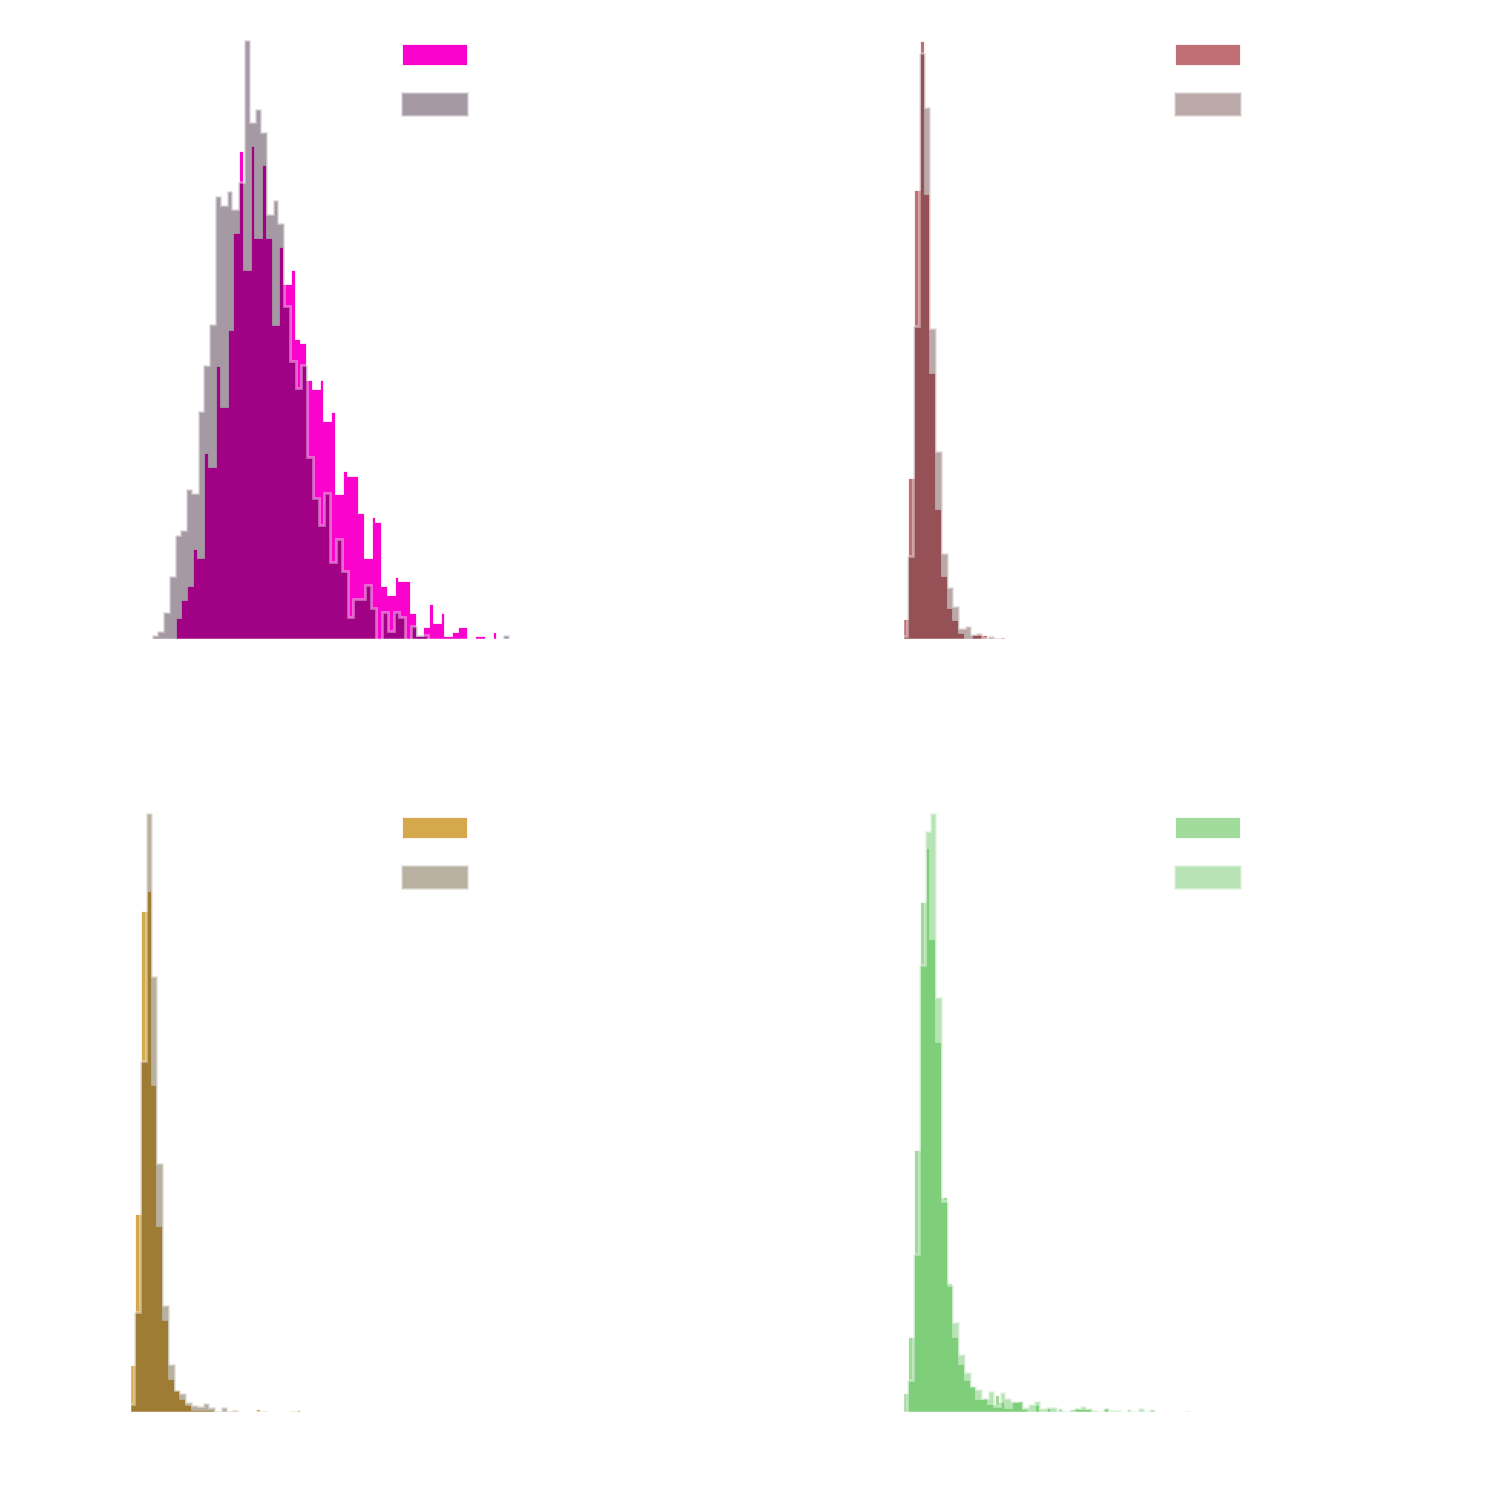

In [ ]:
#for window in results_10.columns[7:]:

sns.set_theme(style='ticks',
              context='poster',
              rc={'figure.figsize':(16,16),
                  'font.size':36})
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

fig, axs_list = plt.subplots(2, 2)

count = 0
i_list = ['0_10', '20_30', '40_50', '70_80']

for axs in axs_list:
    for ax in axs:
        i = i_list[count]
        #print(i, j, stats.kstest(results_10[i], results_10[j]))
        ax.hist(results_10[results_10['magnitude']<6.219][i],
                    bins = bin_list,
                    alpha = 1,
                    histtype="stepfilled",
                    color = 'white')
        ax.hist(results_10[results_10['magnitude']>=6.219][i],
                    bins = bin_list,
                    alpha = 1,
                    histtype="stepfilled",
                    color = 'white')
        ax.hist(results_10[results_10['magnitude']<6.219][i],
                    bins = bin_list,
                    alpha = 1.0,
                    label = 'M<6.219',
                    histtype="stepfilled",
                    color = lighten_color(cmc.hawaii((int(i.split('_')[0])/100)), 0.7))
        ax.hist(results_10[results_10['magnitude']>=6.219][i],
                    bins = bin_list,
                    alpha = 0.4,
                    label = 'M>=6.219',
                    histtype="stepfilled",
                    color = lighten_color(cmc.hawaii((int(i.split('_')[0])/100)), 1.3))
        ax.legend(facecolor = '#002147', edgecolor = 'white', labelcolor = 'white', fontsize = 24, framealpha=0)
        #plt.title(f'P value of KS: {stats.kstest(results_10[i], results_10[j]).pvalue:.3e}')
        ax.set_xlim(0, 1)
        ax.set_xlabel("Proportion of duration")
        ax.set_ylabel("Number of events")

        print(stats.kstest(results_10[results_10['magnitude']<6.219][i],results_10[results_10['magnitude']>=6.219][i]))
        count += 1


#axs.set_title(f"{stats.kstest(results_10[results_10['magnitude']<6.219][window],results_10[results_10['magnitude']>=6.219][window]).pvalue:.3e}")
plt.tight_layout()
plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/poster/ks_test_M6_219.png', dpi = 300, transparent = True)
plt.show()